In [29]:
!pip install git+https://github.com/huseinzol05/malaya.git/

  Cloning https://github.com/huseinzol05/malaya.git/ to /tmp/pip-req-build-s7ajmmra
  Running command git clone --filter=blob:none --quiet https://github.com/huseinzol05/malaya.git/ /tmp/pip-req-build-s7ajmmra
  Resolved https://github.com/huseinzol05/malaya.git/ to commit 06a92a8e608bf136e8dbe93469e32d4cf9b8d53f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import malaya
from gensim.models import Word2Vec
import fasttext
import nltk
nltk.download('punkt')
import re
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import itertools
from collections import Counter

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import networkx as nx

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
df = pd.read_csv("/kaggle/input/depress-suicide-cp/depressed_suicide.csv")

In [32]:
df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis = 1)

In [33]:
df.head()

,text,class,translated_text
0,Am I weird I don't get affected by compliments...,0,Adakah saya pelik saya tidak terpengaruh denga...
1,Finally 2020 is almost over... So I can never ...,0,"Akhirnya 2020 hampir berakhir ... Oleh itu, sa..."
2,i need helpjust help me im crying so hard,1,Saya memerlukan pertolongan untuk menolong say...
3,It ends tonight.I can’t do it anymore. \nI quit.,1,Ia berakhir malam ini. Saya tidak dapat melaku...
4,I took the rest of my sleeping pills and my pa...,1,Saya mengambil sisa pil tidur saya dan ubat pe...


In [34]:
# remove hashtag
hashtag_pattern = r'#\w+\s*'

# remove @ and its word after 
at_pattern = r'@\w+\s*'

# remove url
url_pattern_1 = r'http\S+|www\S+|https\S+'
url_pattern_2 =r'(http[s]?://)?[a-zA-Z0-9]+([-.][a-zA-Z0-9]+)*\.[a-zA-Z]{2,3}(/\S*)?'

# remove any symbols
symbol = r'[^\w\s]'

#remove hyphens that are found in between a word
hyphen_pattern = r'(?<=[a-z])-(?=[a-z])'

#remove double spaces
double_space = r'\s{2}'

#remove digits
digits = '\d+'

# remove words 
angle_bracket_pattern = r'<[^>]+>'

In [35]:
# Define function to remove all noises at once
def sent_preprocess(text):
    cleaned_sentence = re.sub(hashtag_pattern, '', text) # remove hyphen pattern
    cleaned_sentence = re.sub(at_pattern, '', cleaned_sentence)  # remove at pattern
    cleaned_sentence = re.sub(url_pattern_1, '', cleaned_sentence) # remove first url pattern
    cleaned_sentence = re.sub(url_pattern_2, '', cleaned_sentence) # remove second url pattern
    cleaned_sentence = re.sub(angle_bracket_pattern, '', cleaned_sentence) # remove words inside angle bracket 
    cleaned_sentence = re.sub(hyphen_pattern, ' ', cleaned_sentence) # replace hyphen in between words with space
    cleaned_sentence = re.sub(symbol,'', cleaned_sentence) # remove punctuations and special symbols
    cleaned_sentence = re.sub(digits, '', cleaned_sentence) # remove digits
    cleaned_sentence = re.sub(double_space,' ', cleaned_sentence) # change double space to single 
    cleaned_sentence = cleaned_sentence.lower() # lowercased every words
    cleaned_sentence = cleaned_sentence.strip() # strip any next line or tab from sentence 
      
    return cleaned_sentence

In [36]:
df['cleaned_text'] = df['translated_text'].astype(str).apply(lambda x: sent_preprocess(x))

In [37]:
df.head()

,text,class,translated_text,cleaned_text
0,Am I weird I don't get affected by compliments...,0,Adakah saya pelik saya tidak terpengaruh denga...,adakah saya pelik saya tidak terpengaruh denga...
1,Finally 2020 is almost over... So I can never ...,0,"Akhirnya 2020 hampir berakhir ... Oleh itu, sa...",akhirnya hampir berakhir oleh itu saya tidak p...
2,i need helpjust help me im crying so hard,1,Saya memerlukan pertolongan untuk menolong say...,saya memerlukan pertolongan untuk menolong say...
3,It ends tonight.I can’t do it anymore. \nI quit.,1,Ia berakhir malam ini. Saya tidak dapat melaku...,ia berakhir malam ini saya tidak dapat melakuk...
4,I took the rest of my sleeping pills and my pa...,1,Saya mengambil sisa pil tidur saya dan ubat pe...,saya mengambil sisa pil tidur saya dan ubat pe...


In [38]:
url_observation = df[df['translated_text'].str.contains(url_pattern_1, na=False)]
url_observation.head()
observation_228 = df.iloc[228] 
observation_228

text               Ppl who still buy disc games🤡🤡 (Does not apply...
class                                                              0
translated_text    Ppl yang masih membeli permainan cakera (Tidak...
cleaned_text       ppl yang masih membeli permainan cakera tidak ...
Name: 228, dtype: object

In [39]:
# import stop words texts from Kaggle existing dataset 
stop_words = pd.read_csv("/kaggle/input/stop-words-in-28-languages/malaysian.txt", header = None)

In [40]:
# Read first 5 observations of stop words data frame 
stop_words.head()

,0
0,ada
1,adakah
2,adakan
3,adalah
4,adanya


In [41]:
# rename the column 0 into stop_words
stop_words = stop_words.rename(columns = {0: "stop_words"})
# change the stop_words column into list
stop_word_list = stop_words['stop_words'].tolist()
# print the words contain in the stop_word_list and the amount of stop words in it
print(stop_word_list)
print(f"Total number of stopwords: {len(stop_word_list)}")

['ada', 'adakah', 'adakan', 'adalah', 'adanya', 'adapun', 'agak', 'agar', 'akan', 'aku', 'akulah', 'akupun', 'al', 'alangkah', 'allah', 'amat', 'antara', 'antaramu', 'antaranya', 'apa', 'apa-apa', 'apabila', 'apakah', 'apapun', 'atas', 'atasmu', 'atasnya', 'atau', 'ataukah', 'ataupun', 'bagaimana', 'bagaimanakah', 'bagi', 'bagimu', 'baginya', 'bahawa', 'bahawasanya', 'bahkan', 'bahwa', 'banyak', 'banyaknya', 'barangsiapa', 'bawah', 'beberapa', 'begitu', 'begitupun', 'belaka', 'belum', 'belumkah', 'berada', 'berapa', 'berikan', 'beriman', 'berkenaan', 'berupa', 'beserta', 'biarpun', 'bila', 'bilakah', 'bilamana', 'bisa', 'boleh', 'bukan', 'bukankah', 'bukanlah', 'dahulu', 'dalam', 'dalamnya', 'dan', 'dapat', 'dapati', 'dapatkah', 'dapatlah', 'dari', 'daripada', 'daripadaku', 'daripadamu', 'daripadanya', 'demi', 'demikian', 'demikianlah', 'dengan', 'dengannya', 'di', 'dia', 'dialah', 'didapat', 'didapati', 'dimanakah', 'engkau', 'engkaukah', 'engkaulah', 'engkaupun', 'hai', 'hampir', 'ha

In [42]:
def remove_stopwords(text):
    # Tokenize text into individual words
    words = text.split()
    
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_word_list]
    
    # Join filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

In [43]:
# Download PySastrawi from stemming 
!pip install PySastrawi

# Import stemmer function from malaya sastrawi 
sastrawi = malaya.stem.sastrawi()

In [44]:
# Define function to lemmatize and remove stop words at the same time
def lemmatize_and_stop_words_removal(text):
    
    # Remove stop words from sentences
    removed_stopwords_text = remove_stopwords(text)
    # Apply lemmatization on words in sentences
    lemmatized_text = sastrawi.stem(removed_stopwords_text)
    
    return lemmatized_text

In [45]:
df['lemmatized_text'] = df['cleaned_text'].apply(lambda x: lemmatize_and_stop_words_removal(x))

In [46]:
df.head()

,text,class,translated_text,cleaned_text,lemmatized_text
0,Am I weird I don't get affected by compliments...,0,Adakah saya pelik saya tidak terpengaruh denga...,adakah saya pelik saya tidak terpengaruh denga...,pelik pengaruh puji asal kenal asa baik asing ...
1,Finally 2020 is almost over... So I can never ...,0,"Akhirnya 2020 hampir berakhir ... Oleh itu, sa...",akhirnya hampir berakhir oleh itu saya tidak p...,akhir akhir dengar tahun buruk sumpah acau tuh...
2,i need helpjust help me im crying so hard,1,Saya memerlukan pertolongan untuk menolong say...,saya memerlukan pertolongan untuk menolong say...,perlu tolong tolong menang kuat
3,It ends tonight.I can’t do it anymore. \nI quit.,1,Ia berakhir malam ini. Saya tidak dapat melaku...,ia berakhir malam ini saya tidak dapat melakuk...,akhir malam laku nsaya henti
4,I took the rest of my sleeping pills and my pa...,1,Saya mengambil sisa pil tidur saya dan ubat pe...,saya mengambil sisa pil tidur saya dan ubat pe...,ambil sisa pil tidur ubat tahan sakit sabar ak...


In [47]:
from nltk.tokenize import word_tokenize

In [48]:
def remove_non_malay(text):
    words = word_tokenize(text)
    
    sentence = []
    for word in words:
        if malaya.dictionary.is_malay(word) == True:
            sentence.append(word)
        else:
            None
    
    sentence = " ".join(sentence)
    
    return sentence

In [49]:
df['final_text'] = df['lemmatized_text'].apply(lambda x: remove_non_malay(x))

In [50]:
df.head()

,text,class,translated_text,cleaned_text,lemmatized_text,final_text
0,Am I weird I don't get affected by compliments...,0,Adakah saya pelik saya tidak terpengaruh denga...,adakah saya pelik saya tidak terpengaruh denga...,pelik pengaruh puji asal kenal asa baik asing ...,pelik pengaruh puji asal kenal asa baik asing ...
1,Finally 2020 is almost over... So I can never ...,0,"Akhirnya 2020 hampir berakhir ... Oleh itu, sa...",akhirnya hampir berakhir oleh itu saya tidak p...,akhir akhir dengar tahun buruk sumpah acau tuh...,akhir akhir dengar tahun buruk sumpah acau tuh...
2,i need helpjust help me im crying so hard,1,Saya memerlukan pertolongan untuk menolong say...,saya memerlukan pertolongan untuk menolong say...,perlu tolong tolong menang kuat,perlu tolong tolong menang kuat
3,It ends tonight.I can’t do it anymore. \nI quit.,1,Ia berakhir malam ini. Saya tidak dapat melaku...,ia berakhir malam ini saya tidak dapat melakuk...,akhir malam laku nsaya henti,akhir malam laku henti
4,I took the rest of my sleeping pills and my pa...,1,Saya mengambil sisa pil tidur saya dan ubat pe...,saya mengambil sisa pil tidur saya dan ubat pe...,ambil sisa pil tidur ubat tahan sakit sabar ak...,ambil sisa pil tidur ubat tahan sakit sabar ak...


In [24]:
from wordcloud import WordCloud

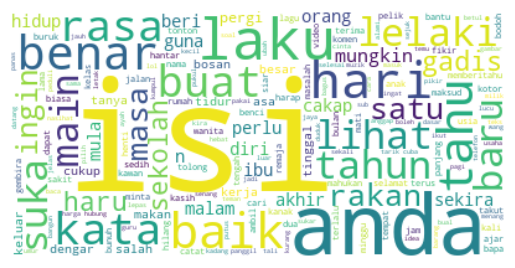

In [29]:
# Create a subset of dataframe where class is non-suicidal
non_suicidal = df.loc[df['class'] == 0]
# Join all texts together with space separator
text_combined_non_suicidal = ' '.join(non_suicidal['final_text'].astype(str))
# Create wordcloud
word_cloud_non_suicidal = WordCloud(collocations = False, background_color = 'white').generate(text_combined_non_suicidal)
# Plot the wordcloud
plt.imshow(word_cloud_non_suicidal, interpolation='bilinear')
plt.axis("off")
plt.show()

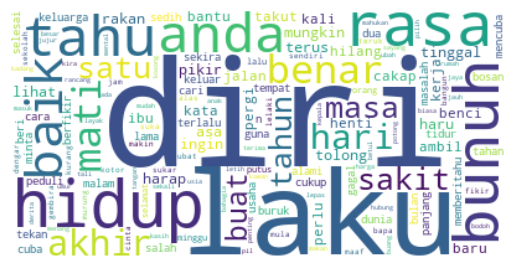

In [30]:
# Create a subset of dataframe where class is suicidal
suicidal = df.loc[df['class'] == 1]
# # Join all texts together with space separator
text_combined_suicidal = ' '.join(suicidal['final_text'].astype(str))
# Create wordcloud
word_cloud_suicidal = WordCloud(collocations = False, background_color = 'white').generate(text_combined_suicidal)
plt.imshow(word_cloud_suicidal, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# Tokenize the text data
tokenized_corpus = [nltk.word_tokenize(text) for text in df['final_text']]
# Instantiate Word2Vec in Continuous bag of words (CBOW) model
w2v_cbow_model = Word2Vec(tokenized_corpus, min_count=1, sg = 0)
# Instantiate Word2Vec in Skip-gram model
w2v_sg_model = Word2Vec(tokenized_corpus, min_count=1, sg = 1)

In [52]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['final_text'])
sequences = tokenizer.texts_to_sequences(df['final_text'])

# Pad sequences to have consistent length
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Create an embedding matrix using Word2Vec word vectors for CBOW
w2v_cbow_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_cbow_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_cbow_model.wv:
        w2v_cbow_embedding_matrix[i] = w2v_cbow_model.wv[word]

In [33]:
# Join all text together
all_text = ' '.join(df['final_text'].values)
#  Tokenize all text
tokens = word_tokenize(all_text)
# Get the word counts for each word tokens
word_counts = Counter(tokens)
# Get the first 20 most common words from all text
most_common_words = [word for word, _ in word_counts.most_common(20)]

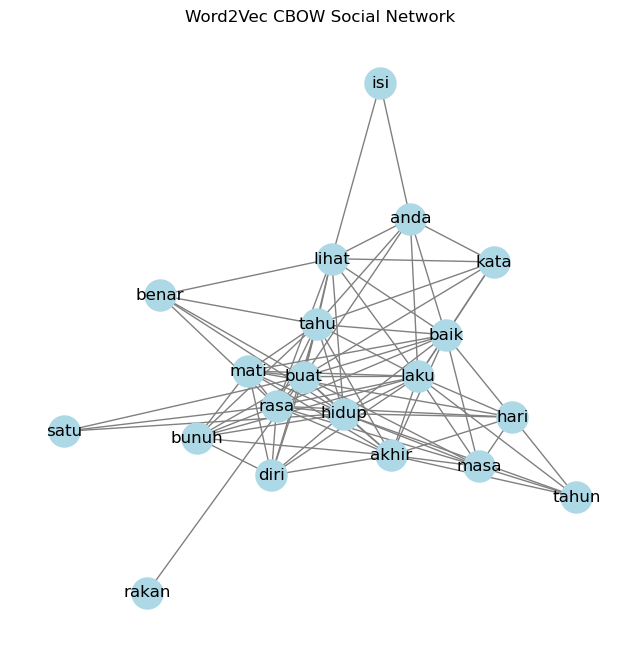

In [34]:
w2v_cbow_word_embeddings = w2v_cbow_model.wv

# Step 1: Define Network Nodes
nodes = most_common_words  # 20 Most common words 

# Step 2: Define Network Edges
edges = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        similarity = w2v_cbow_word_embeddings.similarity(nodes[i], nodes[j])
        if similarity > 0.5:  # Choose a similarity threshold
            edges.append((nodes[i], nodes[j]))

# Step 3: Create Network Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Step 4: Visualize the Network
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color='gray')
plt.title('Word2Vec CBOW Social Network')
plt.axis('off')
plt.show()

In [35]:
# Create an embedding matrix using Word2Vec word vectors for Skip-gram
w2v_sg_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_sg_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_sg_model.wv:
        w2v_sg_embedding_matrix[i] = w2v_sg_model.wv[word]

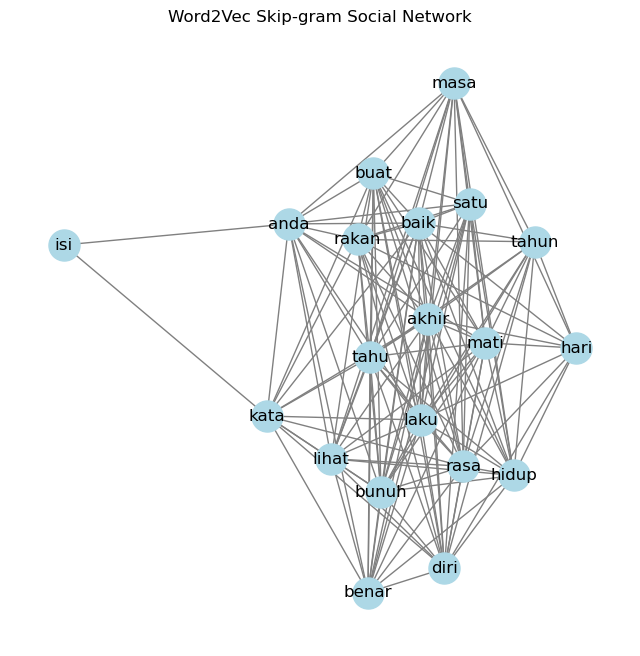

In [36]:
w2v_sg_word_embeddings = w2v_sg_model.wv

# Step 1: Define Network Edges
edges = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        similarity = w2v_sg_word_embeddings.similarity(nodes[i], nodes[j])
        if similarity > 0.5:  # Choose a similarity threshold
            edges.append((nodes[i], nodes[j]))

# Step 2: Create Network Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Step 3: Visualize the Network
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color='gray')
plt.title('Word2Vec Skip-gram Social Network')
plt.axis('off')
plt.show()

In [53]:
# Tokenize the texts
df['tokenized_texts'] = df['final_text'].apply(nltk.word_tokenize)

# Prepare the input file for training
input_file = 'fasttext_input_cbow.txt'
df['tokenized_texts'].apply(lambda x: ' '.join(x)).to_csv(input_file, index=False, header=None)

# Train FastText model with CBOW
ft_cbow_model = fasttext.train_unsupervised(input_file, model='cbow')

Read 0M words
Number of words:  2486
Number of labels: 0
Progress: 100.0% words/sec/thread:  145464 lr:  0.000000 avg.loss:  2.746851 ETA:   0h 0m 0s


In [54]:
# Prepare the input file for training
input_file = 'fasttext_input_sg.txt'
df['tokenized_texts'].apply(lambda x: ' '.join(x)).to_csv(input_file, index=False, header=None)

# Train FastText model with Skip-gram
ft_sg_model = fasttext.train_unsupervised(input_file, model='skipgram')

Read 0M words
Number of words:  2486
Number of labels: 0
Progress: 100.0% words/sec/thread:   97477 lr:  0.000000 avg.loss:  2.602672 ETA:   0h 0m 0s


In [39]:
# Create an embedding matrix using Fasttext word vectors
ft_cbow_embedding_dim = ft_cbow_model.get_dimension()
ft_cbow_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, ft_cbow_embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_cbow_model:
        ft_cbow_embedding_matrix[i] = ft_cbow_model[word]

In [55]:
# Create an embedding matrix using Fasttext word vectors
ft_sg_embedding_dim = ft_sg_model.get_dimension()
ft_sg_embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, ft_sg_embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in ft_sg_model:
        ft_sg_embedding_matrix[i] = ft_sg_model[word]

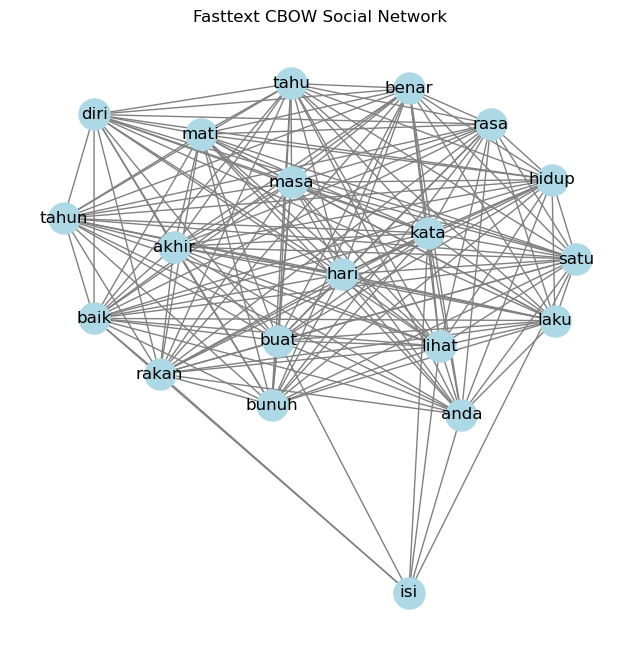

In [41]:
# Step 1: Define Network Edges
edges = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        similarity = ft_cbow_model.get_word_vector(nodes[i]).dot(ft_cbow_model.get_word_vector(nodes[j]))
        if similarity > 0.5:  # Choose a similarity threshold
            edges.append((nodes[i], nodes[j]))

# Step 2: Create Network Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Step 3: Visualize the Network
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color='gray')
plt.title('Fasttext CBOW Social Network')
plt.axis('off')
plt.show()

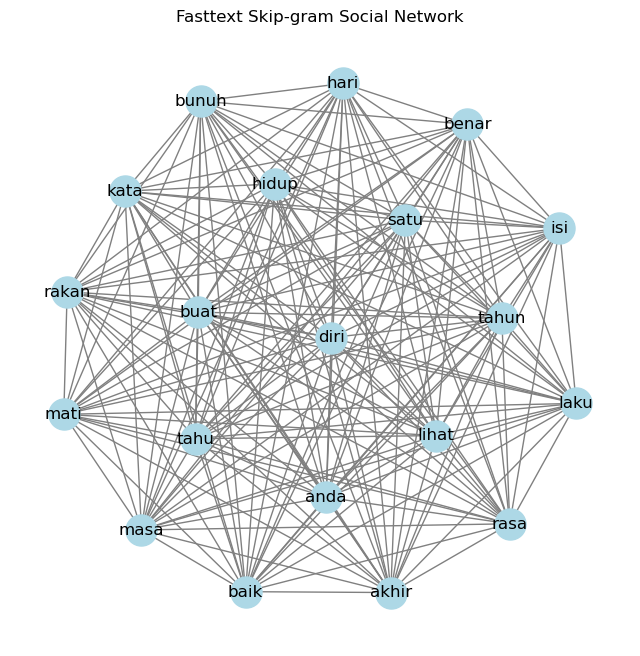

In [42]:
# Step 1: Define Network Edges
edges = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        similarity = ft_sg_model.get_word_vector(nodes[i]).dot(ft_sg_model.get_word_vector(nodes[j]))
        if similarity > 0.5:  # Choose a similarity threshold
            edges.append((nodes[i], nodes[j]))

# Step 2: Create Network Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Step 3: Visualize the Network
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color='gray')
plt.title('Fasttext Skip-gram Social Network')
plt.axis('off')
plt.show()

In [56]:
# Split the dataset into training and temporary sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['final_text'], df['class'], test_size=0.2, random_state=42)

# Split the temporary set into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Print the sizes of the splits
print("Training set size:", len(train_texts))
print("Validation set size:", len(val_texts))
print("Test set size:", len(test_texts))

Training set size: 11330
Validation set size: 1416
Test set size: 1417


In [57]:
# Tokenize and convert train texts to sequences of word indices
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

# Pad sequences to have consistent length for train texts
max_sequence_length = max([len(seq) for seq in sequences])
X_train_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [58]:
# Tokenize and convert validation texts to sequences of word indices
tokenizer.fit_on_texts(val_texts)
sequences = tokenizer.texts_to_sequences(val_texts)

# Pad sequences to have consistent length for validation texts
X_val_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [59]:
# Tokenize and convert test texts to sequences of word indices
tokenizer.fit_on_texts(test_texts)
sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to have consistent length for test texts
X_test_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [60]:
def create_modelcheckpoint(filepath):
    """
    Create model checkpoint by inputting filepath
    
    Args:
        filepath = path to save model in hdf5"""
    
    # Create model checkpoint
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = "val_accuracy",
                                                                 verbose = 1, save_best_only = True,
                                                                 mode = "auto", save_weights_only = False,
                                                                 save_format='h5')
    
    return model_checkpoint

In [61]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [62]:
def load_model_and_predict(model_filepath, test_texts, y_test):
    """
    Load saved model in hdf5 format and predict on prediction set.
    Subsequently calculate metrics of the model
    
    Args:
    model_filepath = path to save model
    test_texts = padded texts of test set
    y_test = true label of classes"""
    
    # Load model
    model = keras.models.load_model(model_filepath)
    # Predict on test_texts
    predictions = model.predict(test_texts)
    # Return the prediction probability where instances of more than 0.5 become 1 and otherwise
    predictions_cat = np.where(predictions > 0.5, 1, 0)
    # Calculate results
    prediction_result = calculate_results(y_test, predictions_cat)
    
    return prediction_result

In [63]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [64]:
def load_model_and_make_cm(model_filepath, test_texts, y_test):
    """
    Load saved model in hdf5 format and predict on prediction set.
    Subsequently calculate metrics of the model
    
    Args:
    model_filepath = path to save model
    test_texts = padded texts of test set
    y_test = true label of classes"""
    
    # Load model
    model = keras.models.load_model(model_filepath)
    # Predict on test_texts
    predictions = model.predict(test_texts)
    # Return the prediction probability where instances of more than 0.5 become 1 and otherwise
    predictions_cat = np.where(predictions > 0.5, 1, 0)
    # plot confusion matrix
    make_confusion_matrix(y_test, predictions_cat)

In [65]:
# Plot the validation and training data separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(history.history['loss']) + 1)

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [46]:
# Create the bi-LSTM model
model1 = Sequential()
model1.add(Embedding(len(tokenizer.word_index) + 1, w2v_cbow_model.vector_size, weights=[w2v_cbow_embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model1.add(Bidirectional(LSTM(128)))
model1.add(Dense(1, activation='sigmoid'))

In [47]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
tf.random.set_seed(42)

cp1 = create_modelcheckpoint("bilstm_cbow_w2v.hdf5")

bilstm_w2v_cbow = model1.fit(X_train_padded, train_labels, epochs=10, batch_size=32, validation_data=(X_val_padded, val_labels), callbacks = [cp1])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
353/355 [============================>.] - ETA: 0s - loss: 0.4126 - accuracy: 0.8283WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7a4d492c6c20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_accuracy improved from -inf to 0.84605, saving model to bilstm_cbow_w2v.hdf5
355/355 [================

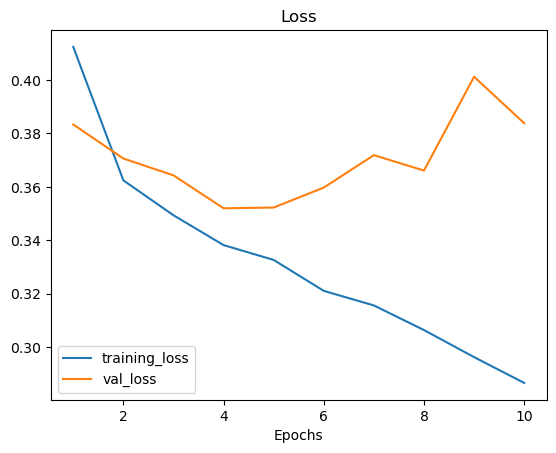

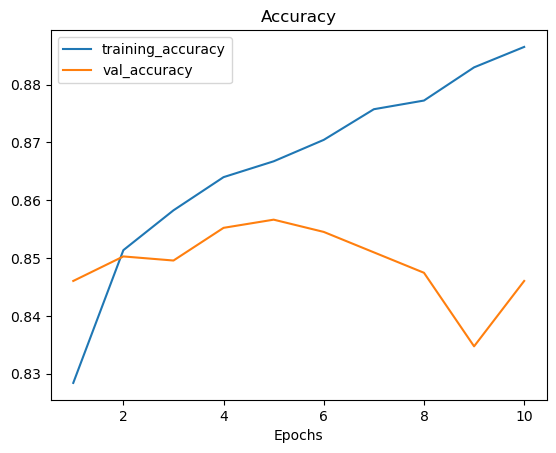

In [49]:
plot_loss_curves(bilstm_w2v_cbow)

In [50]:
bilstm_w2v_cbow_result = load_model_and_predict("bilstm_cbow_w2v.hdf5", X_test_padded, test_labels)
print(bilstm_w2v_cbow_result)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 11ms/step
{'accuracy': 86.66196189131969, 'precision': 0.8656511506193934, 'recall': 0.8666196189131969, 'f1': 0.8648962993917679}


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 9ms/step


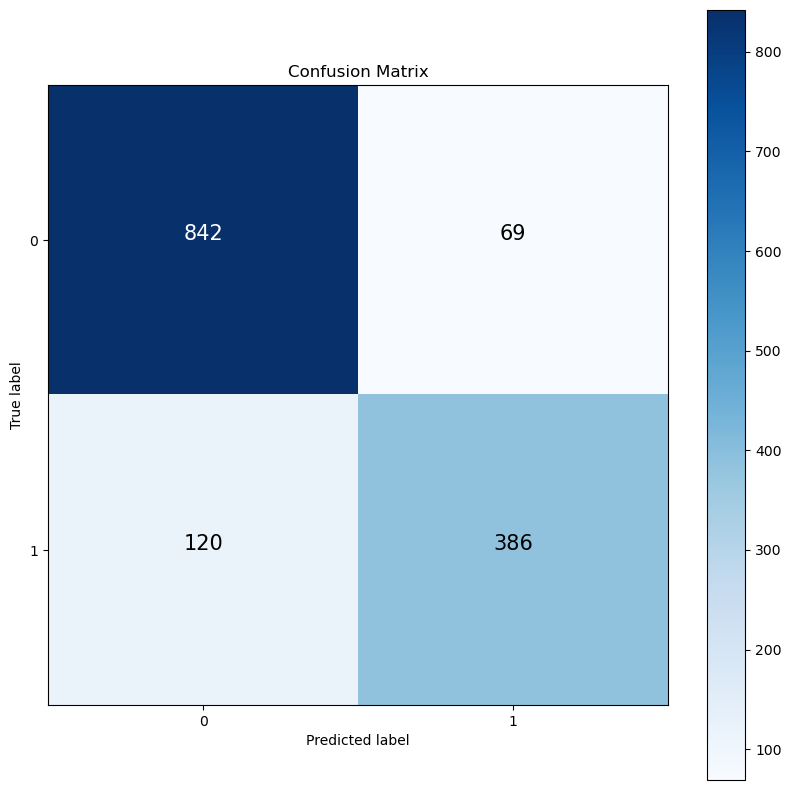

In [51]:
load_model_and_make_cm("bilstm_cbow_w2v.hdf5", X_test_padded, test_labels)

In [52]:
# Create the bi-LSTM model
model2 = Sequential()
model2.add(Embedding(len(tokenizer.word_index) + 1, w2v_sg_model.vector_size, weights=[w2v_sg_embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(1, activation='sigmoid'))

In [53]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
tf.random.set_seed(42)

cp2 = create_modelcheckpoint("bilstm_sg_w2v.hdf5")

bilstm_w2v_sg = model2.fit(X_train_padded, train_labels, epochs=10, batch_size=32, validation_data=(X_val_padded, val_labels), callbacks = [cp2])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
353/355 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8123WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7a4d355775b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_accuracy improved from -inf to 0.83828, saving model to bilstm_sg_w2v.hdf5
355/355 [==================

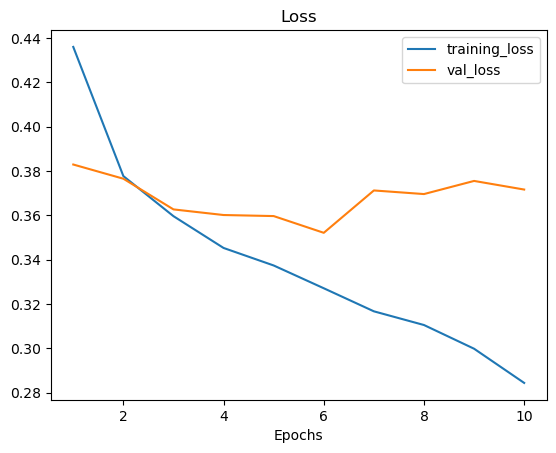

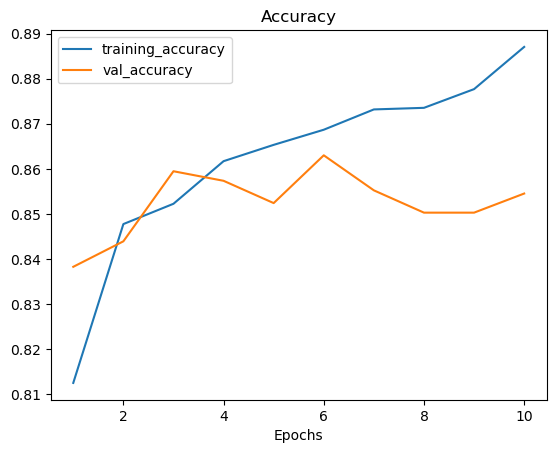

In [55]:
plot_loss_curves(bilstm_w2v_sg)

In [56]:
bilstm_w2v_sg_result = load_model_and_predict("bilstm_sg_w2v.hdf5", X_test_padded, test_labels)
print(bilstm_w2v_sg_result)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 11ms/step
{'accuracy': 86.80310515172901, 'precision': 0.8671001349330721, 'recall': 0.8680310515172901, 'f1': 0.867319099542114}


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 8ms/step


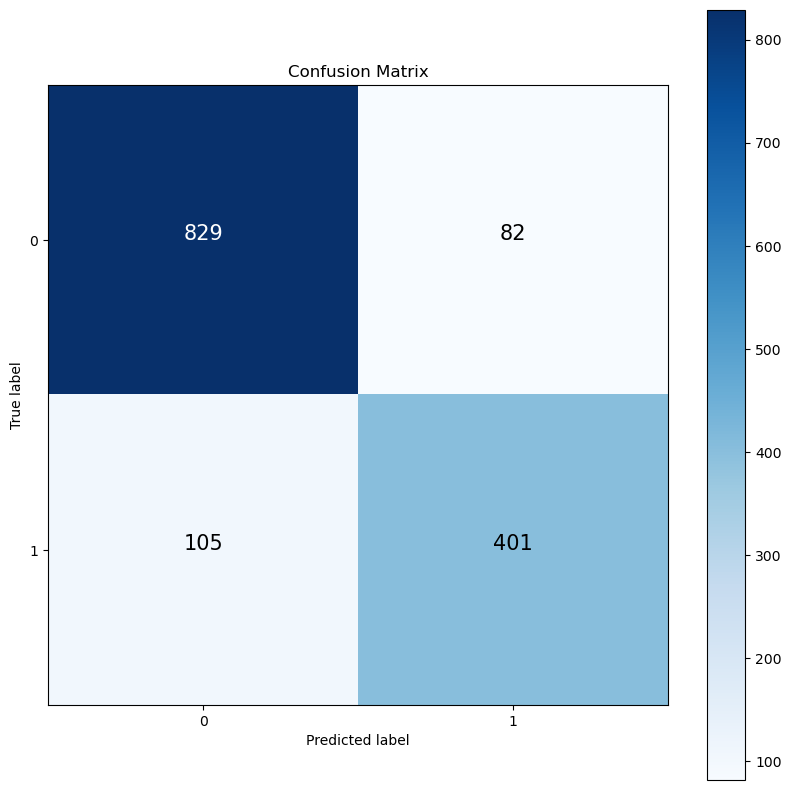

In [57]:
load_model_and_make_cm("bilstm_sg_w2v.hdf5", X_test_padded, test_labels)

In [58]:
# Create the bi-LSTM model
model3 = Sequential()
model3.add(Embedding(len(tokenizer.word_index) + 1, ft_cbow_model.get_dimension(), weights=[ft_cbow_embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model3.add(Bidirectional(LSTM(128)))
model3.add(Dense(1, activation='sigmoid'))

In [59]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
tf.random.set_seed(42)

cp3 = create_modelcheckpoint("bilstm_cbow_ft.hdf5")

bilstm_ft_cbow = model3.fit(X_train_padded, train_labels, epochs=10, batch_size=32, validation_data=(X_val_padded, val_labels), callbacks = [cp3])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
355/355 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.8127WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7a4d33971c60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_accuracy improved from -inf to 0.83475, saving model to bilstm_cbow_ft.hdf5
355/355 [=================

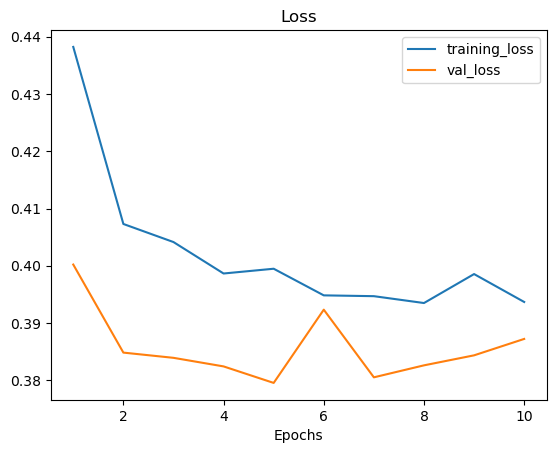

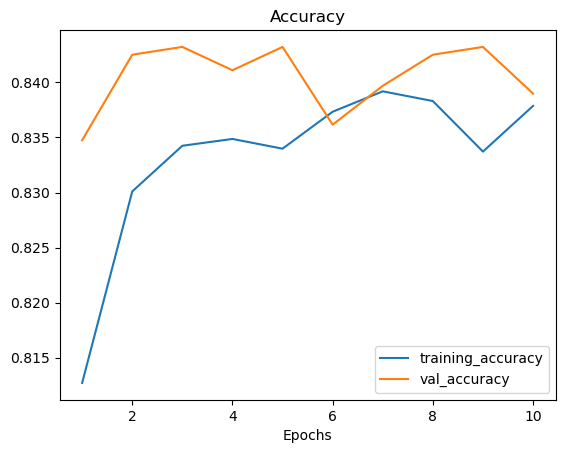

In [61]:
plot_loss_curves(bilstm_ft_cbow)

In [62]:
bilstm_ft_cbow_result = load_model_and_predict("bilstm_cbow_ft.hdf5", X_test_padded, test_labels)
print(bilstm_ft_cbow_result)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 12ms/step
{'accuracy': 85.8151023288638, 'precision': 0.8574131591896478, 'recall': 0.858151023288638, 'f1': 0.8556380999370592}


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 10ms/step


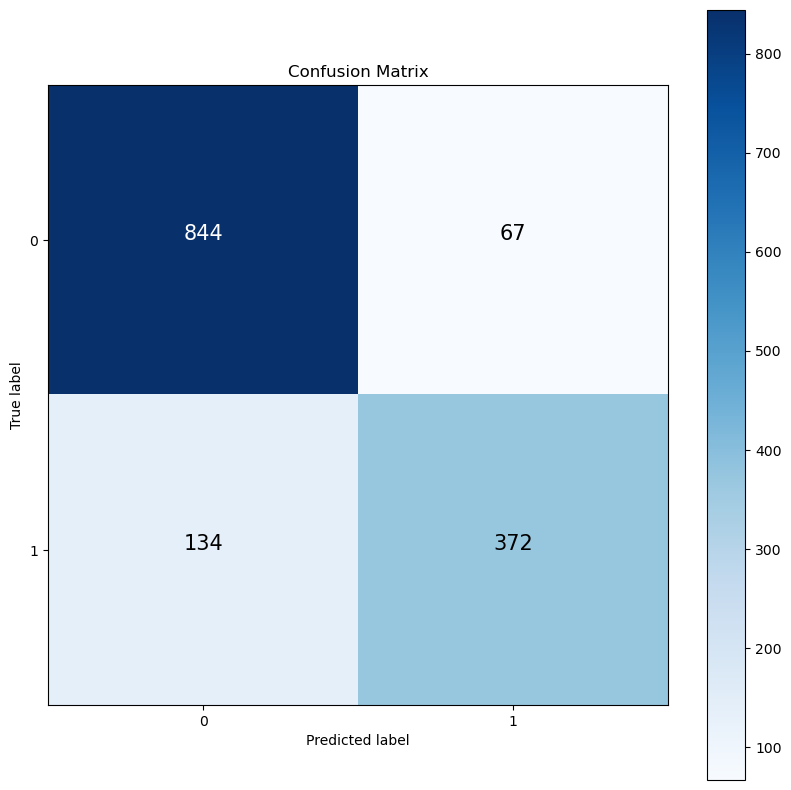

In [63]:
load_model_and_make_cm("bilstm_cbow_ft.hdf5", X_test_padded, test_labels)

In [64]:
# Create the bi-LSTM model
model4 = Sequential()
model4.add(Embedding(len(tokenizer.word_index) + 1, ft_sg_model.get_dimension(), weights=[ft_sg_embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model4.add(Bidirectional(LSTM(128)))
model4.add(Dense(1, activation='sigmoid'))

In [65]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
tf.random.set_seed(42)

cp4 = create_modelcheckpoint("bilstm_sg_ft.hdf5")

bilstm_ft_sg = model4.fit(X_train_padded, train_labels, epochs=10, batch_size=32, validation_data=(X_val_padded, val_labels), callbacks = [cp4])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
355/355 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.7841WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7a490fcb36d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: val_accuracy improved from -inf to 0.80720, saving model to bilstm_sg_ft.hdf5
355/355 [===================

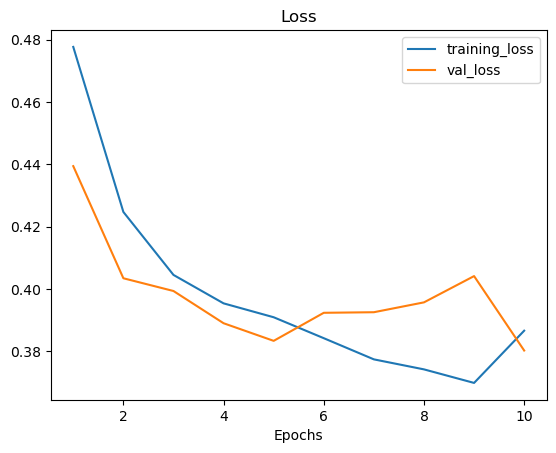

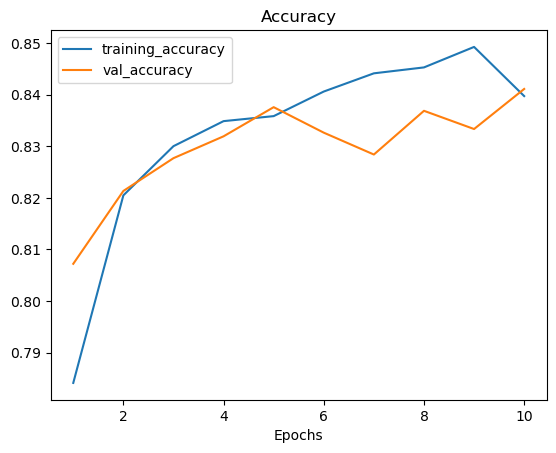

In [67]:
plot_loss_curves(bilstm_ft_sg)

In [68]:
bilstm_ft_sg_result = load_model_and_predict("bilstm_sg_ft.hdf5", X_test_padded, test_labels)
print(bilstm_ft_sg_result)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 11ms/step
{'accuracy': 87.2971065631616, 'precision': 0.8729137659483776, 'recall': 0.8729710656316161, 'f1': 0.8706810475586717}


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: torchlibrosa is not installed. Please install it and try again.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
45/45 [==============================] - 1s 10ms/step


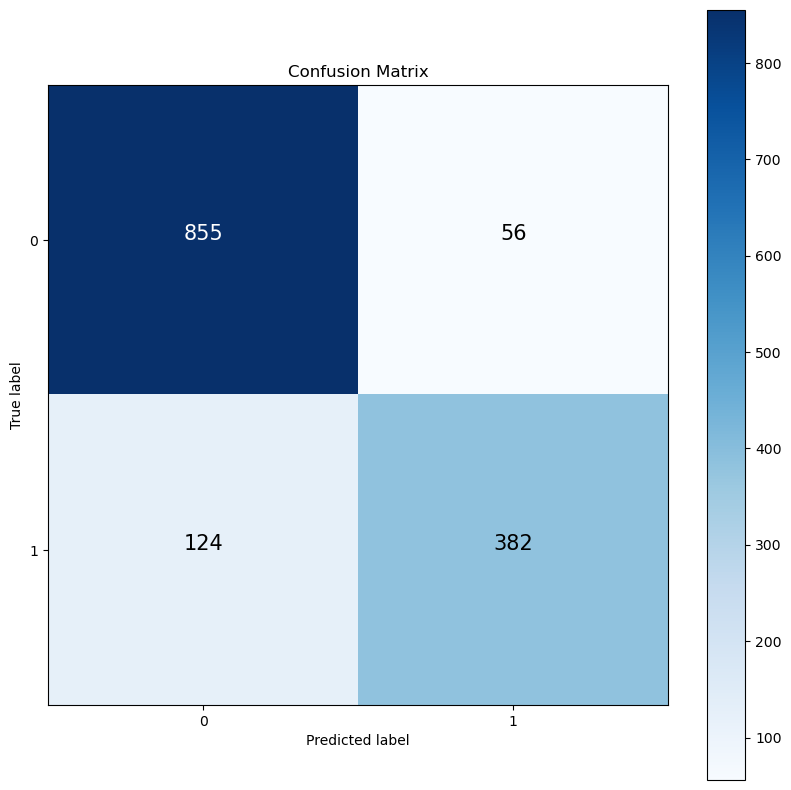

In [69]:
load_model_and_make_cm("bilstm_sg_ft.hdf5", X_test_padded, test_labels)